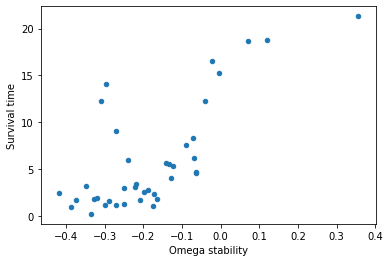

In [15]:
# Загрузим данные с помощью модуля Pandas в объект DataFrame
import pandas as pd
omega_stability = pd.read_csv('omega_stability.csv')

# Проведем первичную обработку данных
omega_stability = omega_stability.T
omega_stability = omega_stability.drop(index = "Name")
omega_stability.columns = ["Omega stability", "Survival time"]

# Преобразуем значения ячеек в числовые
omega_stability["Omega stability"] = omega_stability["Omega stability"].astype(float)
omega_stability["Survival time"] = omega_stability["Survival time"].astype(float)

x = omega_stability["Omega stability"].values
y = omega_stability["Survival time"].values

# Проведем визуализацию
omega_stability.plot(kind="scatter", x="Omega stability", y="Survival time")

In [16]:
# Построение LTS-оценки
def c_step(x, y, x0, model_func, tolerance, max_iter, h0):
    import math
    import random
    import numpy as np
    from scipy.optimize import least_squares
    from scipy.optimize import curve_fit 
    residual_func = lambda a, x, y: model_func(x, a) - y
    i = 1
    H1 = random.sample(range(len(x)), h0)
    Q1 = 9999999
    prev = 0
    error = abs(Q1-prev)
    theta = []
    # Получение x0
    x0 = least_squares(residual_func, x0, loss="linear", args=(x, y)).x
    while error > tolerance and i < max_iter:
        theta = least_squares(residual_func, x0, loss="linear", args=(x[H1], y[H1])).x
        est = model_func(x, theta)
        e = y - est
        prev = Q1
        Q1 = sum(e**2)
        error = abs(Q1 - prev)
        pi = np.argsort(np.abs(e))
        H1 = pi[:h0]
        i += 1
        #print(error)
    return theta

In [3]:
def loo_cross_validation_lts(x, y, model_func, h0):
    import math
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    loo = LeaveOneOut()
    predicts = []    
    for train, test in loo.split(x):
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        a = c_step(x, y, [0, 0, 0, 0], model_func, 1e-7, 500, h0)
        predict = model_func(x_test, a)
        predicts.append(predict)
    rmse = math.sqrt(mean_squared_error(y, predicts))
    return rmse, a

In [17]:
def cube_func(x, a):
    return a[0] + a[1] * x + a[2] * x**2 + a[3] * x**3
def cube_func_ols(x, a0, a1, a2, a3):
    return a0 + a1 * x + a2 * x**2 + a3 * x**3

In [5]:
d = {}
cv_m, a_m = 300, []
h0 = 0
for i in range(22, 40):
    cv, a = loo_cross_validation_lts(x, y, cube_func, i)
    d[i] = a
    if cv < cv_m:
        cv_m = cv
        a_m = a
        h0 = i
    print("i " + str(i))
    print(cv)
print("min cv ", cv_m)
print("h0", h0)
print(a_m)

i 22
6.252509140604601
i 23
3.621368633537184
i 24
3.6175333002487244
i 25
3.667434172131083
i 26
7.779852895198172
i 27
4.510458377412608
i 28
3.5879870186613516
i 29
3.528767101604445
i 30
9.782217939496595
i 31
3.6473786149198792
i 32
3.719276575839222
i 33
3.6686615290072746
i 34
9.940597284804017
i 35
3.6268423144297284
i 36
3.6334863734613347
i 37
3.5158045126742272
i 38
3.4829005116691896
i 39
3.444861579883074
min cv  3.444861579883074
h0 39
[  12.09694901   49.76389472    4.50501477 -179.41888608]


[  12.09694892   49.76389417    4.50501634 -179.41887845]


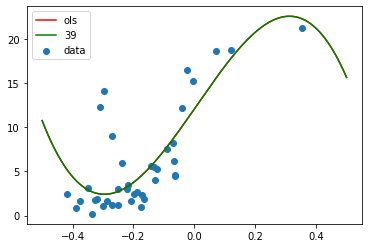

In [6]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
ax.scatter(x, y)
x_plot = np.linspace(-0.5, 0.5, num=1000)
# ols
from scipy.optimize import curve_fit
a, _ = curve_fit(cube_func_ols, x, y)
print(a)
y_plot = cube_func(x_plot, a)
ax.plot(x_plot, y_plot, c="r")
#ax.legend(("ols", "data"))

#37
#h0 = 37
y_plot = cube_func(x_plot, d[h0])
ax.plot(x_plot, y_plot, c="g")
ax.legend(("ols", h0, "data"))

In [7]:
# M-estimators


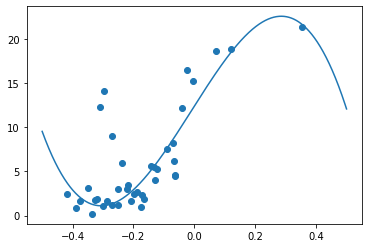

In [8]:
from scipy.optimize import least_squares
residual_func = lambda a, x, y: cube_func(x, a) - y
theta = least_squares(residual_func, [13.2172348, 59.92121269, -14.74252034, -249.17161382], loss="huber", args=(x, y))
a_m = theta.x
fig, ax = plt.subplots()
ax.scatter(x, y)
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = a_m[0] + a_m[1]*x_plot + a_m[2]*x_plot**2 + a_m[3]*x_plot**3
ax.plot(x_plot, y_plot)

In [9]:
def loo_cross_validation_robust(x, y, model_func):
    import math
    from scipy.optimize import curve_fit 
    import numpy as np
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import LeaveOneOut
    residual_func = lambda a, x, y: model_func(x, a) - y
    loo = LeaveOneOut()
    predicts = []    
    for train, test in loo.split(x):
        x_train = x[train]
        y_train = y[train]
        x_test = x[test]
        y_test = y[test]
        robust = least_squares(residual_func, [13.2172348, 59.92121269, -14.74252034, -249.17161382], f_scale = 0.1, loss='arctan', args=(x_train, y_train))
        param = robust.x
        predict = model_func(x_test, param)
        predicts.append(predict)
    rmse = math.sqrt(mean_squared_error(y, predicts))
    return rmse

In [10]:
print(loo_cross_validation_robust(x, y, cube_func))

5.270981519267634


In [11]:
#----------------------------------------------------------------------------------------------------

In [18]:
def lin_ols(x, a0, a1):
    return a0 + a1*x;

In [19]:
# Новая LOO кросс-валидация
def new_loo_cv(x, y, model_func):
    import math
    from scipy.optimize import curve_fit 
    import numpy as np
    SE = 0
    for i in range(len(x)):
        test_x = x[i]
        test_y = y[i]
        x_new = np.delete(x, i)
        y_new = np.delete(y, i)
        a, _ = curve_fit(model_func, x_new, y_new)
        exact_val = model_func(test_x, a[0], a[1])
        SE+=(test_y - exact_val)**2
    RMSE = math.sqrt(SE/len(x))
    return RMSE

In [14]:
print(new_loo_cv(x, y, cube_func_ols))

TypeError: cube_func_ols() missing 2 required positional arguments: 'a2' and 'a3'

In [ ]:
print(new_loo_cv(x, y, lin_ols))

In [20]:
# Новая LOO кросс-валидация для LTS
def new_loo_cv_lts(x, y, model_func, h0):
    import math
    from scipy.optimize import curve_fit 
    import numpy as np
    SE = 0
    for i in range(len(x)):
        test_x = x[i]
        test_y = y[i]
        x_new = np.delete(x, i)
        y_new = np.delete(y, i)
        a = c_step(x_new, y_new, [0, 0, 0, 0], model_func, 1e-7, 500, h0)
        exact_val = model_func(test_x, a)
        SE+=(test_y - exact_val)**2
    RMSE = math.sqrt(SE/len(x))
    return (RMSE, a)

In [56]:
for h in range(20, 39):
    print(h)
    print(new_loo_cv_lts(x, y, cube_func, h))

20
(26.414176804191545, array([-2.87503935e-03,  4.78524498e+01, -3.47190380e+02,  7.65067994e+02]))
21
(4.552595645147088, array([  2.16257347, -23.60535235, 147.57905374, -86.50488231]))
22
(6.36935596231915, array([  2.08645524, -19.11059343, 103.87613776,   8.65502822]))
23
(17.21858228269374, array([ 2.03759631e+00,  1.73951546e-01, -7.08593593e+01,  3.58714474e+02]))
24
(5.269884423931099, array([  2.25113242, -24.39773813, 139.75527392, -69.41152936]))
25
(4.508060587916972, array([  2.0945472 , -19.54291173, 112.3111234 , -34.8013844 ]))
26
(7.989587327918832, array([  2.10958052, -11.74393519,  46.48043981,  94.39052309]))
27
(4.832310173243859, array([  2.39276521, -21.07093943, 109.47319851, -25.67413802]))
28
(7.685392719027284, array([  2.39830683, -19.11591397,  80.85493506,  56.79892257]))
29
(7.8766071424826745, array([  2.4793293 , -20.49348046,  81.78514845,  60.80956566]))
30
(4.73277271455638, array([  2.99310868, -35.86541535, 176.20836679, -92.91041236]))
31
(5.11

In [41]:
# Новая LOO кросс-валидация для LTS
def new_loo_cv_robust(x, y, model_func):
    #from IPython.core.debugger import set_trace
    import math
    from scipy.optimize import curve_fit 
    import numpy as np
    from scipy.optimize import least_squares
    SE = 0
    residual_func = lambda a, x, y: model_func(x, a) - y
    for i in range(len(x)):
        test_x = x[i]
        test_y = y[i]
        x_new = np.delete(x, i)
        y_new = np.delete(y, i)
        #set_trace()
        ak = least_squares(residual_func,  [  12.67122481,   57.87558868,   -8.33038016, -232.57309354], 
                           loss='huber', args=(x_new, y_new)).x

        exact_val = model_func(test_x, ak)
        SE+=(test_y - exact_val)**2
    RMSE = math.sqrt(SE/len(x))
    return (RMSE, ak)

In [43]:
print(new_loo_cv_robust(x, y, cube_func))

(6.536163915308875, array([  12.42743866,   55.43049303,   -5.49440249, -219.91136077]))


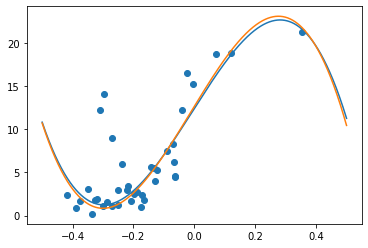

In [44]:
from scipy.optimize import least_squares
x = omega_stability["Omega stability"].values
y = omega_stability["Survival time"].values
#residual_func = lambda a, x, y: cube_func(x, a) - y
#theta = least_squares(residual_func, [13.2172348, 59.92121269, -14.74252034, -249.17161382], loss="huber", args=(x, y))
a_m = [  12.42743866,   55.43049303,   -5.49440249, -219.91136077] 
fig, ax = plt.subplots()
ax.scatter(x, y)
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = a_m[0] + a_m[1]*x_plot + a_m[2]*x_plot**2 + a_m[3]*x_plot**3
ax.plot(x_plot, y_plot)

# cv 4.87
a_m = [  12.67122481,   57.87558868,   -8.33038016, -232.57309354]
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = a_m[0] + a_m[1]*x_plot + a_m[2]*x_plot**2 + a_m[3]*x_plot**3
ax.plot(x_plot, y_plot)
# оранжевый - LTS

M-оценка не дает минимального результата, т.к. LTS на примерно таких же коэффициентах выдаёт ещё большее значение Кросс-Валидации

In [48]:
x_new = x + abs(np.min(x))

In [ ]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 1, num=1000)
y_plot = weibull([0.5, 5], x_plot)
ax.plot(x_plot, y_plot)

In [49]:
# теперь подготовим исходные данные 
# выполним сортировку
x, y = zip(*sorted(zip(x_new, y)))
x = np.asarray(x)
y = np.asarray(y)

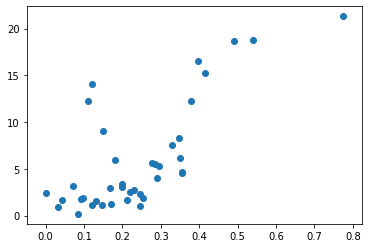

In [50]:
# визуадизируем новые данные
plt.scatter(x, y)


In [ ]:
plt.plot(x, y)

In [27]:
def weibull(a, x):
    return 21.3*(1-np.exp(-(x/a[0])**a[1]))

In [30]:
# определим функцию отклонений
def weibull_residual(a, x, y):
    return 21.3*(1-np.exp(-(x/a[0])**a[1])) - y

In [51]:
res_robust = least_squares(weibull_residual, [1, 1], loss='huber', args=(x, y)).x

C:\ProgramData\Anaconda3\envs\omega_stability\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


In [52]:
res_robust

array([0.41483944, 3.51312491])

In [1]:
fig, ax = plt.subplots()
x_plot = np.linspace(0, 1, num=1000)
# линейная функция потерь
y_plot = weibull([0.43821255, 2.67001618] , x_plot)
ax.plot(x_plot, y_plot)
# хьюбер

y_plot = weibull(res_robust, x_plot)
ax.plot(x_plot, y_plot)
ax.scatter(x, y)

NameError: name 'plt' is not defined

In [45]:
def new_loo_cv_robust(x, y, model_func):
    import math
    import numpy as np
    from scipy.optimize import least_squares
    from IPython.core.debugger import set_trace
    SE = 0
    residual_func = lambda a, x, y: model_func(a, x) - y
    for i in range(len(x)):
        x_test = x[i]
        y_test = y[i]
        x_train = np.delete(x, i)
        y_train = np.delete(y, i)
        #set_trace()
        an = least_squares(residual_func, np.ones(2), loss='huber', args=(x_train, y_train)).x
        exact_val = model_func(an, x_test)
        SE+=(y_test - exact_val)**2
    RMSE = math.sqrt(SE/len(x))
    return (RMSE, an)

In [55]:
new_loo_cv_robust(x, y, weibull)

C:\ProgramData\Anaconda3\envs\omega_stability\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in power
  


(3.8715476773981035, array([0.41483955, 3.51312247]))

In [ ]:
plt.scatter(x, y)
x_plot = x
y_plot = weibull([0.41788069, 3.45097678], x_plot)
plt.plot(x_plot, y_plot)